In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch as tt
import torch.nn as nn
import torch.optim as oo
import rl.modular as mod
import rl.dqn as dqn
from rl.exp import validate_episode, validate_episodes, validate_episode_sum
import gymnasium as gym
from gymnasium.spaces import Box, Discrete

In [3]:
dtype = tt.float32
device = tt.device("cuda" if tt.cuda.is_available() else "cpu")
factory = dict(device=device, dtype=dtype)

## Environment Setup


In [4]:
import rl.jenv as jenv

In [5]:
task_list = jenv.generate_task_list(total=100, seed=99)
num_exec = 2
env = jenv.envF(task_list, num_exec)
validations_envs = [jenv.envF(task_list, num_exec)]

In [6]:
obs, info = env.reset()
cs = 0
ac = []
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = truncated or terminated
    cs += reward
    ac.append(action)
print(ac)
print(cs)

[np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)

In [7]:
import gymnasium.utils.env_checker as env_checker

env_checker.check_env(env)

c:\Users\rashm\Documents\IITP\Year_02\MTP\code\virtual_env\Lib\site-packages\gymnasium\utils\env_checker.py:225: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
c:\Users\rashm\Documents\IITP\Year_02\MTP\code\virtual_env\Lib\site-packages\gymnasium\utils\env_checker.py:229: UserWarning: WARN: A Box observation space maximum value is -infinity. This is probably too high.
  logger.warn(
c:\Users\rashm\Documents\IITP\Year_02\MTP\code\virtual_env\Lib\site-packages\gymnasium\utils\env_checker.py:321: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make
  logger.warn(


In [8]:
def cfopt_ADAM(
    model,
    device_type,
    weight_decay=1e-2,
    learning_rate=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
):
    optimizer = tt.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        betas=betas,
        eps=eps,
    )
    return optimizer

In [9]:
value_thetaF = lambda: mod.dense(
    in_dim=env.observation_space.shape[0],
    layer_dims=[400, 300],
    out_dim=env.action_space.n,
    actFs=[nn.ReLU(), nn.ReLU()],
    use_bias=True,
    use_biasL=True,
    **factory
)
value_theta = value_thetaF()
print(value_theta)
print(mod.count(value_theta), "parameters")

Sequential(
  (0): Linear(in_features=6, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=2, bias=True)
)
123702 parameters


In [10]:
load_theta = ""
# load_theta="c1_dqn_01/3500.pie" # load to continue training

if load_theta:
    print(f"Loading pie from {load_theta}")
    print(value_theta.load_state_dict(dqn.load_pie(load_theta).theta.state_dict()))

In [11]:
# optimizers
weight_decay = 0.0  # 1e-6
learning_rate = 0.00005


epochs = 10000
batch_size = 8
learn_times = 16
tuf = 64

gamma = 0.99
polyak = 0.0
double = False

epsilonStart = 1.0
epsilonEnd = 0.2
emap = mod.Remap(Input_Range=(0.0, 1.0), Output_Range=(epsilonStart, epsilonEnd))
epsilonF = lambda e: emap(e)
epsilonSeed = 15

memory_capacity = int(1e6)
min_memory = int(1e3)

n_validations = int(epochs * 0.01)

n_checkpoints = int(epochs * 0.001)  # n_validations

explore_size_mul = 1.0
explore_size = int(explore_size_mul * (batch_size * learn_times))

save_at = "DQN"

exp = None

c:\Users\rashm\Documents\IITP\Year_02\MTP\code\rl\modular.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_copy = tt.load(buffer)


[*] Explored Min-Memory [1000] Steps
Checkpoint @ DQN\pre.pie
 [Pre-Validation] :: Return:505.55897328237484, Steps:100.0


  1%|          | 101/10000 [00:05<08:34, 19.25it/s]

 [Validation] :: Return:539.151941120393, Steps:100.0


  2%|▏         | 203/10000 [00:10<08:23, 19.46it/s]

 [Validation] :: Return:500.0, Steps:100.0


  3%|▎         | 303/10000 [00:15<08:06, 19.94it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


  4%|▍         | 402/10000 [00:20<09:33, 16.73it/s]

 [Validation] :: Return:790.581745320599, Steps:100.0


  5%|▌         | 502/10000 [00:25<07:53, 20.05it/s]

 [Validation] :: Return:618.0555065619366, Steps:100.0


  6%|▌         | 601/10000 [00:30<09:46, 16.02it/s]

 [Validation] :: Return:787.142774145795, Steps:100.0


  7%|▋         | 701/10000 [00:35<08:16, 18.75it/s]

 [Validation] :: Return:516.2949880201437, Steps:100.0


  8%|▊         | 802/10000 [00:41<08:33, 17.93it/s]

 [Validation] :: Return:714.2735503656821, Steps:100.0


  9%|▉         | 902/10000 [00:46<07:39, 19.79it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 10%|█         | 1002/10000 [00:51<08:01, 18.67it/s]

Checkpoint @ DQN\1000.pie
 [Validation] :: Return:517.9972756341348, Steps:100.0


 11%|█         | 1102/10000 [00:56<08:30, 17.41it/s]

 [Validation] :: Return:751.4208914176179, Steps:100.0


 12%|█▏        | 1202/10000 [01:02<08:58, 16.33it/s]

 [Validation] :: Return:729.5175811695435, Steps:100.0


 13%|█▎        | 1302/10000 [01:08<08:33, 16.93it/s]

 [Validation] :: Return:775.9646230544311, Steps:100.0


 14%|█▍        | 1402/10000 [01:14<09:38, 14.87it/s]

 [Validation] :: Return:650.5758870291318, Steps:100.0


 15%|█▌        | 1502/10000 [01:21<11:43, 12.08it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 16%|█▌        | 1602/10000 [01:28<09:53, 14.15it/s]

 [Validation] :: Return:772.9085915055252, Steps:100.0


 17%|█▋        | 1702/10000 [01:35<09:00, 15.36it/s]

 [Validation] :: Return:790.7822708556076, Steps:100.0


 18%|█▊        | 1802/10000 [01:41<08:39, 15.78it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 19%|█▉        | 1902/10000 [01:48<08:46, 15.38it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 20%|██        | 2002/10000 [01:54<08:58, 14.84it/s]

Checkpoint @ DQN\2000.pie
 [Validation] :: Return:505.55897328237484, Steps:100.0


 21%|██        | 2102/10000 [02:01<08:51, 14.85it/s]

 [Validation] :: Return:635.3543086991559, Steps:100.0


 22%|██▏       | 2202/10000 [02:07<08:40, 14.98it/s]

 [Validation] :: Return:524.1669062669803, Steps:100.0


 23%|██▎       | 2302/10000 [02:14<08:42, 14.74it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 24%|██▍       | 2402/10000 [02:21<08:57, 14.14it/s]

 [Validation] :: Return:793.424988958276, Steps:100.0


 25%|██▌       | 2502/10000 [02:28<08:37, 14.48it/s]

 [Validation] :: Return:521.394056121244, Steps:100.0


 26%|██▌       | 2602/10000 [02:35<08:41, 14.18it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 27%|██▋       | 2702/10000 [02:41<08:40, 14.01it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 28%|██▊       | 2802/10000 [02:49<08:41, 13.80it/s]

 [Validation] :: Return:524.1669062669803, Steps:100.0


 29%|██▉       | 2902/10000 [02:56<08:35, 13.77it/s]

 [Validation] :: Return:721.6292810799038, Steps:100.0


 30%|███       | 3002/10000 [03:03<08:21, 13.95it/s]

Checkpoint @ DQN\3000.pie
 [Validation] :: Return:796.1318871601754, Steps:100.0


 31%|███       | 3102/10000 [03:10<08:29, 13.54it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 32%|███▏      | 3202/10000 [03:18<08:48, 12.86it/s]

 [Validation] :: Return:805.5173575565364, Steps:100.0


 33%|███▎      | 3302/10000 [03:26<09:00, 12.40it/s]

 [Validation] :: Return:583.621948142055, Steps:100.0


 34%|███▍      | 3402/10000 [03:33<08:35, 12.81it/s]

 [Validation] :: Return:557.7845438179273, Steps:100.0


 35%|███▌      | 3502/10000 [03:41<08:11, 13.22it/s]

 [Validation] :: Return:557.6811381010779, Steps:100.0


 36%|███▌      | 3602/10000 [03:48<08:23, 12.70it/s]

 [Validation] :: Return:741.2289883379697, Steps:100.0


 37%|███▋      | 3702/10000 [03:56<09:07, 11.50it/s]

 [Validation] :: Return:514.5544251043417, Steps:100.0


 38%|███▊      | 3802/10000 [04:04<08:22, 12.34it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 39%|███▉      | 3902/10000 [04:12<08:08, 12.49it/s]

 [Validation] :: Return:723.4997093111008, Steps:100.0


 40%|████      | 4002/10000 [04:20<08:07, 12.31it/s]

Checkpoint @ DQN\4000.pie
 [Validation] :: Return:766.9757921720712, Steps:100.0


 41%|████      | 4102/10000 [04:29<08:20, 11.78it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 42%|████▏     | 4202/10000 [04:37<08:01, 12.05it/s]

 [Validation] :: Return:545.6736685301597, Steps:100.0


 43%|████▎     | 4302/10000 [04:45<07:59, 11.89it/s]

 [Validation] :: Return:537.5251593502983, Steps:100.0


 44%|████▍     | 4401/10000 [04:55<11:17,  8.26it/s]

 [Validation] :: Return:680.6052577145651, Steps:100.0


 45%|████▌     | 4501/10000 [05:06<10:12,  8.97it/s]

 [Validation] :: Return:505.55897328237484, Steps:100.0


 46%|████▌     | 4600/10000 [05:15<07:44, 11.64it/s]

 [Validation] :: Return:551.3077610727212, Steps:100.0


 47%|████▋     | 4702/10000 [05:24<07:34, 11.67it/s]

 [Validation] :: Return:634.7629622330965, Steps:100.0


 48%|████▊     | 4802/10000 [05:32<07:36, 11.39it/s]

 [Validation] :: Return:609.7044692080273, Steps:100.0


 49%|████▉     | 4902/10000 [05:41<07:25, 11.44it/s]

 [Validation] :: Return:662.6607234203864, Steps:100.0


 50%|█████     | 5000/10000 [05:49<07:16, 11.46it/s]

Checkpoint @ DQN\5000.pie
 [Validation] :: Return:585.9847527054584, Steps:100.0


 51%|█████     | 5100/10000 [05:58<07:35, 10.75it/s]

 [Validation] :: Return:521.407340583894, Steps:100.0


 52%|█████▏    | 5202/10000 [06:07<07:10, 11.14it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 53%|█████▎    | 5300/10000 [06:16<07:40, 10.21it/s]

 [Validation] :: Return:527.8072745304395, Steps:100.0


 54%|█████▍    | 5400/10000 [06:25<07:02, 10.89it/s]

 [Validation] :: Return:837.6027007720949, Steps:100.0


 55%|█████▌    | 5500/10000 [06:34<07:04, 10.60it/s]

 [Validation] :: Return:667.3409811479273, Steps:100.0


 56%|█████▌    | 5600/10000 [06:43<07:13, 10.16it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 57%|█████▋    | 5700/10000 [06:52<06:42, 10.70it/s]

 [Validation] :: Return:660.6850433799772, Steps:100.0


 58%|█████▊    | 5802/10000 [07:02<06:42, 10.42it/s]

 [Validation] :: Return:840.3397056787909, Steps:100.0


 59%|█████▉    | 5900/10000 [07:11<06:49, 10.02it/s]

 [Validation] :: Return:817.1121611892329, Steps:100.0


 60%|██████    | 6001/10000 [07:21<06:29, 10.27it/s]

Checkpoint @ DQN\6000.pie
 [Validation] :: Return:701.162166540867, Steps:100.0


 61%|██████    | 6101/10000 [07:30<06:29, 10.00it/s]

 [Validation] :: Return:677.7190772062431, Steps:100.0


 62%|██████▏   | 6201/10000 [07:42<06:52,  9.20it/s]

 [Validation] :: Return:717.5667322029458, Steps:100.0


 63%|██████▎   | 6301/10000 [07:52<06:14,  9.88it/s]

 [Validation] :: Return:657.444474322326, Steps:100.0


 64%|██████▍   | 6401/10000 [08:02<06:04,  9.86it/s]

 [Validation] :: Return:725.3017672370529, Steps:100.0


 65%|██████▌   | 6501/10000 [08:12<06:59,  8.33it/s]

 [Validation] :: Return:745.0590124745095, Steps:100.0


 66%|██████▌   | 6601/10000 [08:22<06:05,  9.31it/s]

 [Validation] :: Return:571.9522505882685, Steps:100.0


 67%|██████▋   | 6701/10000 [08:32<05:33,  9.88it/s]

 [Validation] :: Return:645.5316265933694, Steps:100.0


 68%|██████▊   | 6801/10000 [08:42<05:50,  9.13it/s]

 [Validation] :: Return:733.426266745598, Steps:100.0


 69%|██████▉   | 6901/10000 [08:53<05:24,  9.55it/s]

 [Validation] :: Return:772.8644128261094, Steps:100.0


 70%|███████   | 7001/10000 [09:03<05:17,  9.45it/s]

Checkpoint @ DQN\7000.pie
 [Validation] :: Return:557.7425050745434, Steps:100.0


 71%|███████   | 7101/10000 [09:14<05:26,  8.89it/s]

 [Validation] :: Return:540.269991251612, Steps:100.0


 72%|███████▏  | 7201/10000 [09:24<05:03,  9.23it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 73%|███████▎  | 7301/10000 [09:35<04:53,  9.19it/s]

 [Validation] :: Return:538.2644054655183, Steps:100.0


 74%|███████▍  | 7401/10000 [09:46<04:54,  8.82it/s]

 [Validation] :: Return:734.2205359055586, Steps:100.0


 75%|███████▌  | 7501/10000 [09:56<04:43,  8.81it/s]

 [Validation] :: Return:549.7842029832582, Steps:100.0


 76%|███████▌  | 7601/10000 [10:08<04:47,  8.36it/s]

 [Validation] :: Return:544.572886768388, Steps:100.0


 77%|███████▋  | 7701/10000 [10:19<04:24,  8.69it/s]

 [Validation] :: Return:729.8547698174335, Steps:100.0


 78%|███████▊  | 7801/10000 [10:30<04:15,  8.59it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 79%|███████▉  | 7901/10000 [10:41<04:04,  8.58it/s]

 [Validation] :: Return:810.9936440971027, Steps:100.0


 80%|████████  | 8001/10000 [10:53<04:04,  8.18it/s]

Checkpoint @ DQN\8000.pie
 [Validation] :: Return:537.5251593502983, Steps:100.0


 81%|████████  | 8101/10000 [11:04<03:37,  8.72it/s]

 [Validation] :: Return:754.7271892141537, Steps:100.0


 82%|████████▏ | 8201/10000 [11:15<03:28,  8.61it/s]

 [Validation] :: Return:698.3495233021434, Steps:100.0


 83%|████████▎ | 8300/10000 [11:26<03:22,  8.38it/s]

 [Validation] :: Return:688.8726685258241, Steps:100.0


 84%|████████▍ | 8401/10000 [11:38<03:08,  8.49it/s]

 [Validation] :: Return:759.6073281613019, Steps:100.0


 85%|████████▌ | 8501/10000 [11:49<02:57,  8.46it/s]

 [Validation] :: Return:575.8872087608221, Steps:100.0


 86%|████████▌ | 8601/10000 [12:00<02:43,  8.57it/s]

 [Validation] :: Return:663.6930889328013, Steps:100.0


 87%|████████▋ | 8701/10000 [12:12<02:28,  8.72it/s]

 [Validation] :: Return:608.6196307849094, Steps:100.0


 88%|████████▊ | 8801/10000 [12:24<02:23,  8.37it/s]

 [Validation] :: Return:517.9972756341348, Steps:100.0


 89%|████████▉ | 8901/10000 [12:35<02:12,  8.28it/s]

 [Validation] :: Return:537.5251593502983, Steps:100.0


 90%|█████████ | 9001/10000 [12:47<02:00,  8.26it/s]

Checkpoint @ DQN\9000.pie
 [Validation] :: Return:517.9972756341348, Steps:100.0


 91%|█████████ | 9101/10000 [12:58<01:47,  8.40it/s]

 [Validation] :: Return:659.9864848136201, Steps:100.0


 92%|█████████▏| 9201/10000 [13:10<01:36,  8.30it/s]

 [Validation] :: Return:641.7821095877056, Steps:100.0


 93%|█████████▎| 9301/10000 [13:22<01:30,  7.72it/s]

 [Validation] :: Return:654.8417722751856, Steps:100.0


 94%|█████████▍| 9401/10000 [13:33<01:09,  8.58it/s]

 [Validation] :: Return:633.0886151462535, Steps:100.0


 95%|█████████▌| 9501/10000 [13:45<00:57,  8.74it/s]

 [Validation] :: Return:646.884171058199, Steps:100.0


 96%|█████████▌| 9601/10000 [13:56<00:47,  8.39it/s]

 [Validation] :: Return:822.9510028420684, Steps:100.0


 97%|█████████▋| 9701/10000 [14:08<00:35,  8.32it/s]

 [Validation] :: Return:736.7673766134542, Steps:100.0


 98%|█████████▊| 9801/10000 [14:19<00:25,  7.80it/s]

 [Validation] :: Return:750.1629899940245, Steps:100.0


 99%|█████████▉| 9901/10000 [14:31<00:11,  8.50it/s]

 [Validation] :: Return:569.3979665117436, Steps:100.0


100%|██████████| 10000/10000 [14:42<00:00, 11.33it/s]


Checkpoint @ DQN\10000.pie
 [Validation] :: Return:640.1956110334338, Steps:100.0
[100.00 %]
Saved @ DQN\final.pie
 [Final-Validation] :: Return:640.1956110334338, Steps:100.0


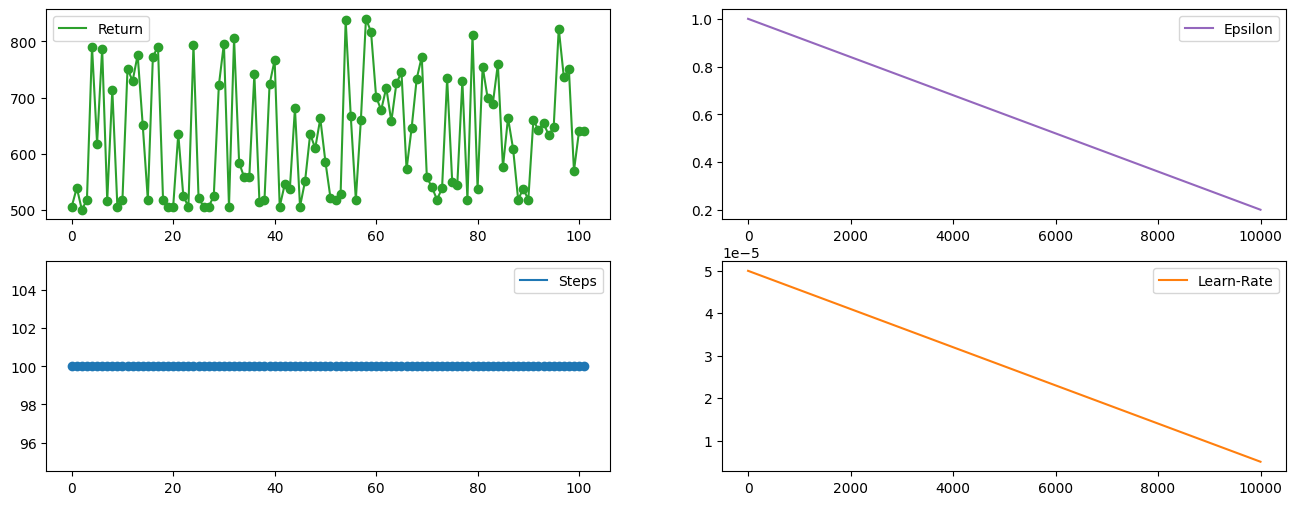

['DQN\\pre.pie', 'DQN\\1000.pie', 'DQN\\2000.pie', 'DQN\\3000.pie', 'DQN\\4000.pie', 'DQN\\5000.pie', 'DQN\\6000.pie', 'DQN\\7000.pie', 'DQN\\8000.pie', 'DQN\\9000.pie', 'DQN\\10000.pie', 'DQN\\final.pie']


In [12]:
np.bool8 = np.bool_

pie, exp, validation_hist, train_hist, fig, checkpoints = dqn.train(
    # policy params [T.P]
    # not required
    # value params [T.V]
    value_theta=value_theta,
    val_opt=cfopt_ADAM(
        model=value_theta,
        device_type=device,
        weight_decay=weight_decay,
        learning_rate=learning_rate,
        betas=(0.9, 0.999),
        eps=1e-8,
    ),
    value_lrsF=oo.lr_scheduler.LinearLR,
    value_lrsA=dict(start_factor=1.0, end_factor=0.1, total_iters=epochs),
    # device params [DEV]
    dtype=dtype,
    device=device,
    # env params (training) [E]
    env=env,
    gamma=gamma,
    polyak=polyak,
    # learning params [L]
    epochs=epochs,
    batch_size=batch_size,
    # verbf=int(epochs/10),
    learn_times=learn_times,
    # explore-exploit [X]
    # explore_heuristic=explore_heuristic,
    explore_size=explore_size,
    epsilonStart=epsilonStart,
    epsilonF=epsilonF,
    epsilonSeed=epsilonSeed,
    reset_seed=None,  # <--- seed supplied to generate task
    # memory params [M]
    memory_capacity=memory_capacity,
    memory_seed=None,
    min_memory=min_memory,
    # validation params [V]
    validations_envs=validations_envs,
    validation_freq=int(epochs / n_validations),
    validation_max_steps=None,  # inf horizon
    validation_reset_seed=None,
    validation_episodes=1,
    validation_verbose=0,
    validation_render=False,
    # algorithm-specific params [A]
    double=double,
    tuf=tuf,
    # result params [R]
    plot_results=True,
    save_at=save_at,
    checkpoint_freq=int(epochs / n_checkpoints) if n_checkpoints > 0 else 0,
    explorer=exp,
    clear_memory=False,
)

print(checkpoints)

In [14]:
obs, info = env.reset()
cs = 0
ac = []
done = False
while not done:
    action = pie.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    done = truncated or terminated
    cs += reward
    ac.append(action)
    # if terminated or truncated:
    # obs, info = env.reset()
print(ac)
print(cs)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
640.1956110334338
